In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from typing import List, Tuple
import matplotlib.pyplot as plt
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.transforms import Compose
from torchvision import transforms
from torchvision.datasets import ImageFolder

import numpy as np

In [7]:
from models import SlimWide, torchvision_default_initialize_weights
from data_prep import stratified_split, DataSubSet

In [8]:
tf_eval = Compose([transforms.Grayscale(),
                   transforms.ToTensor(),
                   transforms.Normalize((0.4862745,), (0.1388,)),
                  ])

tf_train = Compose([transforms.Grayscale(),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize((0.4862745,), (0.1388,)),
                   ])

ds = ImageFolder('../photomask_trainingdata')
eval_idx, train_idx = stratified_split([x[1] for x in ds.samples])

ds_eval = DataSubSet(ds, eval_idx, transform=tf_eval)
ds_train = DataSubSet(ds, train_idx, transform=tf_train)

In [9]:
m = SlimWide()
torchvision_default_initialize_weights(m)

In [10]:
def sorted_sums(ds, m):
    sums = defaultdict(list)
    for i in range(len(ds)):
        x, label = ds[i]
        y = m(x.unsqueeze(0))
        s = y.sum().item()
        sums[label].append(s)
    return {k: sorted(v) for k,v in sums.items()}

Text(0.5, 1.0, 'EVAL')

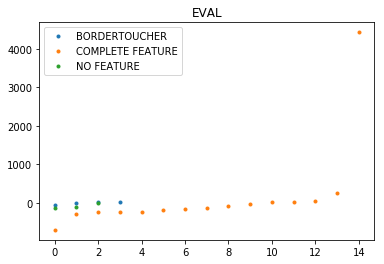

In [11]:
r = sorted_sums(ds_eval, m)
for k, v in r.items():
    label = label={v:k for k,v in ds.class_to_idx.items()}[k]
    plt.plot(v, ".", label=label)
plt.legend()
plt.title("EVAL")

Text(0.5, 1.0, 'TRAIN')

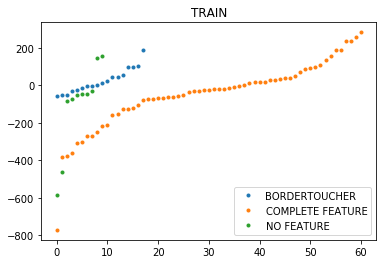

In [13]:
r = sorted_sums(ds_train, m)
for k, v in r.items():
    label = label={v:k for k,v in ds.class_to_idx.items()}[k]
    plt.plot(v, ".", label=label)
plt.legend()
plt.title("TRAIN")

In [22]:
def plot_pred(img, label):
    plt.imshow(img)
    plt.title(label)

In [23]:
def get_label(ds, k:int) -> str:
    return {v:k for k,v in ds.class_to_idx.items()}[k]

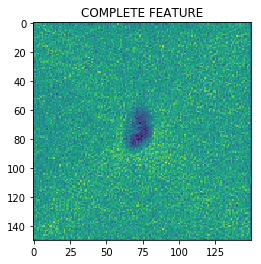

In [24]:
x, cls = ds_eval[11]
x = x.unsqueeze(0)
label = get_label(ds, cls)

y_mask = m(x).data.cpu().squeeze(1)[0].numpy()
plot_pred(x.numpy().squeeze(), label+" INPUT")
plot_pred(y_mask, label)

In [27]:
def loss_hinge(result_sum, min_sum:float = 2000, max_sum:float = 6000):
    loss = F.relu(result_sum - max_sum) + \
           F.relu(-result_sum + min_sum)
    return loss

losses = []
for s in torch.linspace(0, 100, 100):
    losses.append(loss_hinge(s, 40, 80))

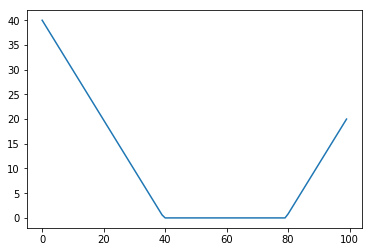

In [28]:
plt.plot(losses)

In [ ]:
TRUTH_BOUNDS = {"NO FEATURE": (0, 100),
                "COMPLETE FEATURE": (1500, 4000), 
                "BORDERTOUCHER" : (1000, 3500)
               }

# TRAINING

In [31]:
from torch import optim

In [32]:
optimizer = optim.SGD(m.parameters(), lr=1e-5, momentum=0.9, weight_decay=1e-4)

In [14]:
def train_epoch(ds, m, optimizer):
    pass